# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 50, 50, 50, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=50, bias=True)
    (2): Tanh()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Tanh()
    (7): Linear(in_features=50, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 50, 50, 50, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # Aufruf LR scheduler für reduce on plateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.2802
Epoch 1/200, Iteration 2/25, Loss: 0.2329
Epoch 1/200, Iteration 3/25, Loss: 0.1045
Epoch 1/200, Iteration 4/25, Loss: 0.1374
Epoch 1/200, Iteration 5/25, Loss: 0.1424
Epoch 1/200, Iteration 6/25, Loss: 0.1002
Epoch 1/200, Iteration 7/25, Loss: 0.0716
Epoch 1/200, Iteration 8/25, Loss: 0.0680
Epoch 1/200, Iteration 9/25, Loss: 0.0522
Epoch 1/200, Iteration 10/25, Loss: 0.0541
Epoch 1/200, Iteration 11/25, Loss: 0.0578
Epoch 1/200, Iteration 12/25, Loss: 0.0481
Epoch 1/200, Iteration 13/25, Loss: 0.0665
Epoch 1/200, Iteration 14/25, Loss: 0.0534
Epoch 1/200, Iteration 15/25, Loss: 0.0511
Epoch 1/200, Iteration 16/25, Loss: 0.0642
Epoch 1/200, Iteration 17/25, Loss: 0.0431
Epoch 1/200, Iteration 18/25, Loss: 0.0254
Epoch 1/200, Iteration 19/25, Loss: 0.0332
Epoch 1/200, Iteration 20/25, Loss: 0.0436
Epoch 1/200, Iteration 21/25, Loss: 0.0569
Epoch 1/200, Iteration 22/25, Loss: 0.0622
Epoch 1/200, Iteration 23/25, Loss: 0.0445
Epoch 1/200, Iterati

Epoch 8/200, Iteration 7/25, Loss: 0.0229
Epoch 8/200, Iteration 8/25, Loss: 0.0311
Epoch 8/200, Iteration 9/25, Loss: 0.0190
Epoch 8/200, Iteration 10/25, Loss: 0.0223
Epoch 8/200, Iteration 11/25, Loss: 0.0254
Epoch 8/200, Iteration 12/25, Loss: 0.0225
Epoch 8/200, Iteration 13/25, Loss: 0.0244
Epoch 8/200, Iteration 14/25, Loss: 0.0291
Epoch 8/200, Iteration 15/25, Loss: 0.0340
Epoch 8/200, Iteration 16/25, Loss: 0.0353
Epoch 8/200, Iteration 17/25, Loss: 0.0467
Epoch 8/200, Iteration 18/25, Loss: 0.0243
Epoch 8/200, Iteration 19/25, Loss: 0.0524
Epoch 8/200, Iteration 20/25, Loss: 0.0293
Epoch 8/200, Iteration 21/25, Loss: 0.0201
Epoch 8/200, Iteration 22/25, Loss: 0.0439
Epoch 8/200, Iteration 23/25, Loss: 0.0212
Epoch 8/200, Iteration 24/25, Loss: 0.0326
Epoch 8/200, Iteration 25/25, Loss: 0.0219
Train Error: 
 Accuracy: 45.25%, Avg loss: 0.018935, MRE: 1.064399 

Test Error: 
 Accuracy: 46.0%, Avg loss: 0.018424, MRE: 2.664088 

Epoch 9/200, Iteration 1/25, Loss: 0.0205
Epoch 9/

Epoch 15/200, Iteration 16/25, Loss: 0.0222
Epoch 15/200, Iteration 17/25, Loss: 0.0166
Epoch 15/200, Iteration 18/25, Loss: 0.0343
Epoch 15/200, Iteration 19/25, Loss: 0.0320
Epoch 15/200, Iteration 20/25, Loss: 0.0213
Epoch 15/200, Iteration 21/25, Loss: 0.0184
Epoch 15/200, Iteration 22/25, Loss: 0.0398
Epoch 15/200, Iteration 23/25, Loss: 0.0323
Epoch 15/200, Iteration 24/25, Loss: 0.0371
Epoch 15/200, Iteration 25/25, Loss: 0.0302
Train Error: 
 Accuracy: 65.62%, Avg loss: 0.025288, MRE: 1.084430 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.026427, MRE: 3.813380 

Epoch 16/200, Iteration 1/25, Loss: 0.0264
Epoch 16/200, Iteration 2/25, Loss: 0.0232
Epoch 16/200, Iteration 3/25, Loss: 0.0133
Epoch 16/200, Iteration 4/25, Loss: 0.0290
Epoch 16/200, Iteration 5/25, Loss: 0.0227
Epoch 16/200, Iteration 6/25, Loss: 0.0218
Epoch 16/200, Iteration 7/25, Loss: 0.0195
Epoch 16/200, Iteration 8/25, Loss: 0.0396
Epoch 16/200, Iteration 9/25, Loss: 0.0253
Epoch 16/200, Iteration 10/25, Loss: 

Epoch 22/200, Iteration 19/25, Loss: 0.0210
Epoch 22/200, Iteration 20/25, Loss: 0.0170
Epoch 22/200, Iteration 21/25, Loss: 0.0235
Epoch 22/200, Iteration 22/25, Loss: 0.0271
Epoch 22/200, Iteration 23/25, Loss: 0.0179
Epoch 22/200, Iteration 24/25, Loss: 0.0107
Epoch 22/200, Iteration 25/25, Loss: 0.0166
Train Error: 
 Accuracy: 80.12%, Avg loss: 0.022949, MRE: 1.526521 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.022642, MRE: 4.246162 

Epoch 23/200, Iteration 1/25, Loss: 0.0272
Epoch 23/200, Iteration 2/25, Loss: 0.0191
Epoch 23/200, Iteration 3/25, Loss: 0.0200
Epoch 23/200, Iteration 4/25, Loss: 0.0140
Epoch 23/200, Iteration 5/25, Loss: 0.0342
Epoch 23/200, Iteration 6/25, Loss: 0.0240
Epoch 23/200, Iteration 7/25, Loss: 0.0208
Epoch 23/200, Iteration 8/25, Loss: 0.0159
Epoch 23/200, Iteration 9/25, Loss: 0.0120
Epoch 23/200, Iteration 10/25, Loss: 0.0297
Epoch 23/200, Iteration 11/25, Loss: 0.0169
Epoch 23/200, Iteration 12/25, Loss: 0.0421
Epoch 23/200, Iteration 13/25, Loss: 

Epoch 29/200, Iteration 21/25, Loss: 0.0128
Epoch 29/200, Iteration 22/25, Loss: 0.0474
Epoch 29/200, Iteration 23/25, Loss: 0.0093
Epoch 29/200, Iteration 24/25, Loss: 0.0196
Epoch 29/200, Iteration 25/25, Loss: 0.0224
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.010745, MRE: 0.610558 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.011284, MRE: 1.498798 

Epoch 30/200, Iteration 1/25, Loss: 0.0544
Epoch 30/200, Iteration 2/25, Loss: 0.0184
Epoch 30/200, Iteration 3/25, Loss: 0.0271
Epoch 30/200, Iteration 4/25, Loss: 0.0104
Epoch 30/200, Iteration 5/25, Loss: 0.0124
Epoch 30/200, Iteration 6/25, Loss: 0.0197
Epoch 30/200, Iteration 7/25, Loss: 0.0162
Epoch 30/200, Iteration 8/25, Loss: 0.0086
Epoch 30/200, Iteration 9/25, Loss: 0.0091
Epoch 30/200, Iteration 10/25, Loss: 0.0091
Epoch 30/200, Iteration 11/25, Loss: 0.0163
Epoch 30/200, Iteration 12/25, Loss: 0.0140
Epoch 30/200, Iteration 13/25, Loss: 0.0092
Epoch 30/200, Iteration 14/25, Loss: 0.0206
Epoch 30/200, Iteration 15/25, Loss: 

Epoch 37/200, Iteration 9/25, Loss: 0.0152
Epoch 37/200, Iteration 10/25, Loss: 0.0162
Epoch 37/200, Iteration 11/25, Loss: 0.0104
Epoch 37/200, Iteration 12/25, Loss: 0.0249
Epoch 37/200, Iteration 13/25, Loss: 0.0270
Epoch 37/200, Iteration 14/25, Loss: 0.0095
Epoch 37/200, Iteration 15/25, Loss: 0.0249
Epoch 37/200, Iteration 16/25, Loss: 0.0155
Epoch 37/200, Iteration 17/25, Loss: 0.0166
Epoch 37/200, Iteration 18/25, Loss: 0.0277
Epoch 37/200, Iteration 19/25, Loss: 0.0276
Epoch 37/200, Iteration 20/25, Loss: 0.0147
Epoch 37/200, Iteration 21/25, Loss: 0.0122
Epoch 37/200, Iteration 22/25, Loss: 0.0240
Epoch 37/200, Iteration 23/25, Loss: 0.0175
Epoch 37/200, Iteration 24/25, Loss: 0.0179
Epoch 37/200, Iteration 25/25, Loss: 0.0377
Train Error: 
 Accuracy: 84.38%, Avg loss: 0.008281, MRE: 0.604205 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.008772, MRE: 2.398356 

Epoch 38/200, Iteration 1/25, Loss: 0.0329
Epoch 38/200, Iteration 2/25, Loss: 0.0151
Epoch 38/200, Iteration 3/25, L

Train Error: 
 Accuracy: 80.38%, Avg loss: 0.007996, MRE: 0.503829 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.008397, MRE: 1.767321 

Epoch 45/200, Iteration 1/25, Loss: 0.0136
Epoch 45/200, Iteration 2/25, Loss: 0.0176
Epoch 45/200, Iteration 3/25, Loss: 0.0140
Epoch 45/200, Iteration 4/25, Loss: 0.0084
Epoch 45/200, Iteration 5/25, Loss: 0.0196
Epoch 45/200, Iteration 6/25, Loss: 0.0079
Epoch 45/200, Iteration 7/25, Loss: 0.0111
Epoch 45/200, Iteration 8/25, Loss: 0.0187
Epoch 45/200, Iteration 9/25, Loss: 0.0069
Epoch 45/200, Iteration 10/25, Loss: 0.0182
Epoch 45/200, Iteration 11/25, Loss: 0.0084
Epoch 45/200, Iteration 12/25, Loss: 0.0101
Epoch 45/200, Iteration 13/25, Loss: 0.0093
Epoch 45/200, Iteration 14/25, Loss: 0.0146
Epoch 45/200, Iteration 15/25, Loss: 0.0100
Epoch 45/200, Iteration 16/25, Loss: 0.0069
Epoch 45/200, Iteration 17/25, Loss: 0.0299
Epoch 45/200, Iteration 18/25, Loss: 0.0159
Epoch 45/200, Iteration 19/25, Loss: 0.0081
Epoch 45/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 77.12%, Avg loss: 0.008258, MRE: 0.476533 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.008564, MRE: 1.961973 

Epoch 52/200, Iteration 1/25, Loss: 0.0123
Epoch 52/200, Iteration 2/25, Loss: 0.0207
Epoch 52/200, Iteration 3/25, Loss: 0.0065
Epoch 52/200, Iteration 4/25, Loss: 0.0146
Epoch 52/200, Iteration 5/25, Loss: 0.0090
Epoch 52/200, Iteration 6/25, Loss: 0.0156
Epoch 52/200, Iteration 7/25, Loss: 0.0281
Epoch 52/200, Iteration 8/25, Loss: 0.0317
Epoch 52/200, Iteration 9/25, Loss: 0.0314
Epoch 52/200, Iteration 10/25, Loss: 0.0196
Epoch 52/200, Iteration 11/25, Loss: 0.0112
Epoch 52/200, Iteration 12/25, Loss: 0.0097
Epoch 52/200, Iteration 13/25, Loss: 0.0137
Epoch 52/200, Iteration 14/25, Loss: 0.0119
Epoch 52/200, Iteration 15/25, Loss: 0.0230
Epoch 52/200, Iteration 16/25, Loss: 0.0289
Epoch 52/200, Iteration 17/25, Loss: 0.0186
Epoch 52/200, Iteration 18/25, Loss: 0.0261
Epoch 52/200, Iteration 19/25, Loss: 0.0176
Epoch 52/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 73.0%, Avg loss: 0.009142, MRE: 0.435958 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.009395, MRE: 1.627674 

Epoch 59/200, Iteration 1/25, Loss: 0.0140
Epoch 59/200, Iteration 2/25, Loss: 0.0162
Epoch 59/200, Iteration 3/25, Loss: 0.0104
Epoch 59/200, Iteration 4/25, Loss: 0.0229
Epoch 59/200, Iteration 5/25, Loss: 0.0144
Epoch 59/200, Iteration 6/25, Loss: 0.0101
Epoch 59/200, Iteration 7/25, Loss: 0.0244
Epoch 59/200, Iteration 8/25, Loss: 0.0134
Epoch 59/200, Iteration 9/25, Loss: 0.0210
Epoch 59/200, Iteration 10/25, Loss: 0.0096
Epoch 59/200, Iteration 11/25, Loss: 0.0129
Epoch 59/200, Iteration 12/25, Loss: 0.0140
Epoch 59/200, Iteration 13/25, Loss: 0.0086
Epoch 59/200, Iteration 14/25, Loss: 0.0067
Epoch 59/200, Iteration 15/25, Loss: 0.0060
Epoch 59/200, Iteration 16/25, Loss: 0.0260
Epoch 59/200, Iteration 17/25, Loss: 0.0137
Epoch 59/200, Iteration 18/25, Loss: 0.0247
Epoch 59/200, Iteration 19/25, Loss: 0.0106
Epoch 59/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 92.38%, Avg loss: 0.006255, MRE: 0.389985 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.006517, MRE: 1.679441 

Epoch 66/200, Iteration 1/25, Loss: 0.0090
Epoch 66/200, Iteration 2/25, Loss: 0.0217
Epoch 66/200, Iteration 3/25, Loss: 0.0140
Epoch 66/200, Iteration 4/25, Loss: 0.0074
Epoch 66/200, Iteration 5/25, Loss: 0.0086
Epoch 66/200, Iteration 6/25, Loss: 0.0344
Epoch 66/200, Iteration 7/25, Loss: 0.0266
Epoch 66/200, Iteration 8/25, Loss: 0.0079
Epoch 66/200, Iteration 9/25, Loss: 0.0243
Epoch 66/200, Iteration 10/25, Loss: 0.0138
Epoch 66/200, Iteration 11/25, Loss: 0.0112
Epoch 66/200, Iteration 12/25, Loss: 0.0169
Epoch 66/200, Iteration 13/25, Loss: 0.0095
Epoch 66/200, Iteration 14/25, Loss: 0.0167
Epoch 66/200, Iteration 15/25, Loss: 0.0086
Epoch 66/200, Iteration 16/25, Loss: 0.0286
Epoch 66/200, Iteration 17/25, Loss: 0.0181
Epoch 66/200, Iteration 18/25, Loss: 0.0111
Epoch 66/200, Iteration 19/25, Loss: 0.0102
Epoch 66/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 86.5%, Avg loss: 0.006376, MRE: 0.428378 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006817, MRE: 1.473618 

Epoch 73/200, Iteration 1/25, Loss: 0.0198
Epoch 73/200, Iteration 2/25, Loss: 0.0288
Epoch 73/200, Iteration 3/25, Loss: 0.0147
Epoch 73/200, Iteration 4/25, Loss: 0.0116
Epoch 73/200, Iteration 5/25, Loss: 0.0187
Epoch 73/200, Iteration 6/25, Loss: 0.0101
Epoch 73/200, Iteration 7/25, Loss: 0.0216
Epoch 73/200, Iteration 8/25, Loss: 0.0091
Epoch 73/200, Iteration 9/25, Loss: 0.0072
Epoch 73/200, Iteration 10/25, Loss: 0.0150
Epoch 73/200, Iteration 11/25, Loss: 0.0295
Epoch 73/200, Iteration 12/25, Loss: 0.0058
Epoch 73/200, Iteration 13/25, Loss: 0.0208
Epoch 73/200, Iteration 14/25, Loss: 0.0095
Epoch 73/200, Iteration 15/25, Loss: 0.0089
Epoch 73/200, Iteration 16/25, Loss: 0.0070
Epoch 73/200, Iteration 17/25, Loss: 0.0131
Epoch 73/200, Iteration 18/25, Loss: 0.0186
Epoch 73/200, Iteration 19/25, Loss: 0.0071
Epoch 73/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 89.0%, Avg loss: 0.006282, MRE: 0.382980 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.006602, MRE: 1.601123 

Epoch 80/200, Iteration 1/25, Loss: 0.0174
Epoch 80/200, Iteration 2/25, Loss: 0.0174
Epoch 80/200, Iteration 3/25, Loss: 0.0145
Epoch 80/200, Iteration 4/25, Loss: 0.0172
Epoch 80/200, Iteration 5/25, Loss: 0.0182
Epoch 80/200, Iteration 6/25, Loss: 0.0109
Epoch 80/200, Iteration 7/25, Loss: 0.0163
Epoch 80/200, Iteration 8/25, Loss: 0.0244
Epoch 80/200, Iteration 9/25, Loss: 0.0088
Epoch 80/200, Iteration 10/25, Loss: 0.0104
Epoch 80/200, Iteration 11/25, Loss: 0.0176
Epoch 80/200, Iteration 12/25, Loss: 0.0103
Epoch 80/200, Iteration 13/25, Loss: 0.0101
Epoch 80/200, Iteration 14/25, Loss: 0.0087
Epoch 80/200, Iteration 15/25, Loss: 0.0132
Epoch 80/200, Iteration 16/25, Loss: 0.0164
Epoch 80/200, Iteration 17/25, Loss: 0.0453
Epoch 80/200, Iteration 18/25, Loss: 0.0136
Epoch 80/200, Iteration 19/25, Loss: 0.0131
Epoch 80/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.006212, MRE: 0.385435 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.006360, MRE: 1.515354 

Epoch 87/200, Iteration 1/25, Loss: 0.0189
Epoch 87/200, Iteration 2/25, Loss: 0.0142
Epoch 87/200, Iteration 3/25, Loss: 0.0327
Epoch 87/200, Iteration 4/25, Loss: 0.0089
Epoch 87/200, Iteration 5/25, Loss: 0.0100
Epoch 87/200, Iteration 6/25, Loss: 0.0139
Epoch 87/200, Iteration 7/25, Loss: 0.0102
Epoch 87/200, Iteration 8/25, Loss: 0.0115
Epoch 87/200, Iteration 9/25, Loss: 0.0187
Epoch 87/200, Iteration 10/25, Loss: 0.0197
Epoch 87/200, Iteration 11/25, Loss: 0.0060
Epoch 87/200, Iteration 12/25, Loss: 0.0129
Epoch 87/200, Iteration 13/25, Loss: 0.0112
Epoch 87/200, Iteration 14/25, Loss: 0.0050
Epoch 87/200, Iteration 15/25, Loss: 0.0161
Epoch 87/200, Iteration 16/25, Loss: 0.0110
Epoch 87/200, Iteration 17/25, Loss: 0.0222
Epoch 87/200, Iteration 18/25, Loss: 0.0138
Epoch 87/200, Iteration 19/25, Loss: 0.0121
Epoch 87/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 91.25%, Avg loss: 0.006097, MRE: 0.361697 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006289, MRE: 1.543528 

Epoch 94/200, Iteration 1/25, Loss: 0.0119
Epoch 94/200, Iteration 2/25, Loss: 0.0276
Epoch 94/200, Iteration 3/25, Loss: 0.0154
Epoch 94/200, Iteration 4/25, Loss: 0.0070
Epoch 94/200, Iteration 5/25, Loss: 0.0101
Epoch 94/200, Iteration 6/25, Loss: 0.0122
Epoch 94/200, Iteration 7/25, Loss: 0.0222
Epoch 94/200, Iteration 8/25, Loss: 0.0313
Epoch 94/200, Iteration 9/25, Loss: 0.0149
Epoch 94/200, Iteration 10/25, Loss: 0.0366
Epoch 94/200, Iteration 11/25, Loss: 0.0101
Epoch 94/200, Iteration 12/25, Loss: 0.0100
Epoch 94/200, Iteration 13/25, Loss: 0.0077
Epoch 94/200, Iteration 14/25, Loss: 0.0066
Epoch 94/200, Iteration 15/25, Loss: 0.0092
Epoch 94/200, Iteration 16/25, Loss: 0.0088
Epoch 94/200, Iteration 17/25, Loss: 0.0155
Epoch 94/200, Iteration 18/25, Loss: 0.0118
Epoch 94/200, Iteration 19/25, Loss: 0.0243
Epoch 94/200, Iteration 20/25, Loss: 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.008186, MRE: 2.056045 

Epoch 101/200, Iteration 1/25, Loss: 0.0145
Epoch 101/200, Iteration 2/25, Loss: 0.0158
Epoch 101/200, Iteration 3/25, Loss: 0.0100
Epoch 101/200, Iteration 4/25, Loss: 0.0092
Epoch 101/200, Iteration 5/25, Loss: 0.0201
Epoch 101/200, Iteration 6/25, Loss: 0.0130
Epoch 101/200, Iteration 7/25, Loss: 0.0083
Epoch 101/200, Iteration 8/25, Loss: 0.0333
Epoch 101/200, Iteration 9/25, Loss: 0.0070
Epoch 101/200, Iteration 10/25, Loss: 0.0178
Epoch 101/200, Iteration 11/25, Loss: 0.0192
Epoch 101/200, Iteration 12/25, Loss: 0.0083
Epoch 101/200, Iteration 13/25, Loss: 0.0120
Epoch 101/200, Iteration 14/25, Loss: 0.0092
Epoch 101/200, Iteration 15/25, Loss: 0.0092
Epoch 101/200, Iteration 16/25, Loss: 0.0196
Epoch 101/200, Iteration 17/25, Loss: 0.0113
Epoch 101/200, Iteration 18/25, Loss: 0.0098
Epoch 101/200, Iteration 19/25, Loss: 0.0222
Epoch 101/200, Iteration 20/25, Loss: 0.0212
Epoch 101/200, Iteration 21/25, Loss: 0.00

Train Error: 
 Accuracy: 84.38%, Avg loss: 0.006375, MRE: 0.395847 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.006710, MRE: 1.400580 

Epoch 108/200, Iteration 1/25, Loss: 0.0129
Epoch 108/200, Iteration 2/25, Loss: 0.0153
Epoch 108/200, Iteration 3/25, Loss: 0.0314
Epoch 108/200, Iteration 4/25, Loss: 0.0081
Epoch 108/200, Iteration 5/25, Loss: 0.0236
Epoch 108/200, Iteration 6/25, Loss: 0.0066
Epoch 108/200, Iteration 7/25, Loss: 0.0068
Epoch 108/200, Iteration 8/25, Loss: 0.0133
Epoch 108/200, Iteration 9/25, Loss: 0.0117
Epoch 108/200, Iteration 10/25, Loss: 0.0244
Epoch 108/200, Iteration 11/25, Loss: 0.0169
Epoch 108/200, Iteration 12/25, Loss: 0.0174
Epoch 108/200, Iteration 13/25, Loss: 0.0160
Epoch 108/200, Iteration 14/25, Loss: 0.0142
Epoch 108/200, Iteration 15/25, Loss: 0.0150
Epoch 108/200, Iteration 16/25, Loss: 0.0098
Epoch 108/200, Iteration 17/25, Loss: 0.0132
Epoch 108/200, Iteration 18/25, Loss: 0.0230
Epoch 108/200, Iteration 19/25, Loss: 0.0096
Epoch 108/200, Ite

Epoch 114/200, Iteration 19/25, Loss: 0.0085
Epoch 114/200, Iteration 20/25, Loss: 0.0205
Epoch 114/200, Iteration 21/25, Loss: 0.0114
Epoch 114/200, Iteration 22/25, Loss: 0.0182
Epoch 114/200, Iteration 23/25, Loss: 0.0264
Epoch 114/200, Iteration 24/25, Loss: 0.0101
Epoch 114/200, Iteration 25/25, Loss: 0.0135
Train Error: 
 Accuracy: 89.75%, Avg loss: 0.006357, MRE: 0.380013 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.006569, MRE: 1.638261 

Epoch 115/200, Iteration 1/25, Loss: 0.0250
Epoch 115/200, Iteration 2/25, Loss: 0.0075
Epoch 115/200, Iteration 3/25, Loss: 0.0139
Epoch 115/200, Iteration 4/25, Loss: 0.0084
Epoch 115/200, Iteration 5/25, Loss: 0.0106
Epoch 115/200, Iteration 6/25, Loss: 0.0100
Epoch 115/200, Iteration 7/25, Loss: 0.0129
Epoch 115/200, Iteration 8/25, Loss: 0.0095
Epoch 115/200, Iteration 9/25, Loss: 0.0162
Epoch 115/200, Iteration 10/25, Loss: 0.0116
Epoch 115/200, Iteration 11/25, Loss: 0.0250
Epoch 115/200, Iteration 12/25, Loss: 0.0089
Epoch 115/200, Ite

Epoch 121/200, Iteration 13/25, Loss: 0.0092
Epoch 121/200, Iteration 14/25, Loss: 0.0106
Epoch 121/200, Iteration 15/25, Loss: 0.0183
Epoch 121/200, Iteration 16/25, Loss: 0.0139
Epoch 121/200, Iteration 17/25, Loss: 0.0166
Epoch 121/200, Iteration 18/25, Loss: 0.0098
Epoch 121/200, Iteration 19/25, Loss: 0.0085
Epoch 121/200, Iteration 20/25, Loss: 0.0125
Epoch 121/200, Iteration 21/25, Loss: 0.0133
Epoch 121/200, Iteration 22/25, Loss: 0.0074
Epoch 121/200, Iteration 23/25, Loss: 0.0180
Epoch 121/200, Iteration 24/25, Loss: 0.0215
Epoch 121/200, Iteration 25/25, Loss: 0.0185
Train Error: 
 Accuracy: 92.88%, Avg loss: 0.006114, MRE: 0.378488 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006227, MRE: 1.623322 

Epoch 122/200, Iteration 1/25, Loss: 0.0286
Epoch 122/200, Iteration 2/25, Loss: 0.0089
Epoch 122/200, Iteration 3/25, Loss: 0.0076
Epoch 122/200, Iteration 4/25, Loss: 0.0180
Epoch 122/200, Iteration 5/25, Loss: 0.0150
Epoch 122/200, Iteration 6/25, Loss: 0.0219
Epoch 122/200, 

Train Error: 
 Accuracy: 93.25%, Avg loss: 0.006110, MRE: 0.359936 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006556, MRE: 1.516006 

Epoch 129/200, Iteration 1/25, Loss: 0.0110
Epoch 129/200, Iteration 2/25, Loss: 0.0100
Epoch 129/200, Iteration 3/25, Loss: 0.0150
Epoch 129/200, Iteration 4/25, Loss: 0.0084
Epoch 129/200, Iteration 5/25, Loss: 0.0100
Epoch 129/200, Iteration 6/25, Loss: 0.0106
Epoch 129/200, Iteration 7/25, Loss: 0.0210
Epoch 129/200, Iteration 8/25, Loss: 0.0305
Epoch 129/200, Iteration 9/25, Loss: 0.0098
Epoch 129/200, Iteration 10/25, Loss: 0.0253
Epoch 129/200, Iteration 11/25, Loss: 0.0130
Epoch 129/200, Iteration 12/25, Loss: 0.0145
Epoch 129/200, Iteration 13/25, Loss: 0.0268
Epoch 129/200, Iteration 14/25, Loss: 0.0110
Epoch 129/200, Iteration 15/25, Loss: 0.0237
Epoch 129/200, Iteration 16/25, Loss: 0.0114
Epoch 129/200, Iteration 17/25, Loss: 0.0098
Epoch 129/200, Iteration 18/25, Loss: 0.0064
Epoch 129/200, Iteration 19/25, Loss: 0.0221
Epoch 129/200, Ite

Train Error: 
 Accuracy: 90.25%, Avg loss: 0.006297, MRE: 0.385809 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006417, MRE: 1.666392 

Epoch 136/200, Iteration 1/25, Loss: 0.0359
Epoch 136/200, Iteration 2/25, Loss: 0.0067
Epoch 136/200, Iteration 3/25, Loss: 0.0165
Epoch 136/200, Iteration 4/25, Loss: 0.0093
Epoch 136/200, Iteration 5/25, Loss: 0.0101
Epoch 136/200, Iteration 6/25, Loss: 0.0099
Epoch 136/200, Iteration 7/25, Loss: 0.0115
Epoch 136/200, Iteration 8/25, Loss: 0.0253
Epoch 136/200, Iteration 9/25, Loss: 0.0113
Epoch 136/200, Iteration 10/25, Loss: 0.0155
Epoch 136/200, Iteration 11/25, Loss: 0.0067
Epoch 136/200, Iteration 12/25, Loss: 0.0229
Epoch 136/200, Iteration 13/25, Loss: 0.0103
Epoch 136/200, Iteration 14/25, Loss: 0.0159
Epoch 136/200, Iteration 15/25, Loss: 0.0182
Epoch 136/200, Iteration 16/25, Loss: 0.0069
Epoch 136/200, Iteration 17/25, Loss: 0.0111
Epoch 136/200, Iteration 18/25, Loss: 0.0121
Epoch 136/200, Iteration 19/25, Loss: 0.0180
Epoch 136/200, Ite

Train Error: 
 Accuracy: 93.12%, Avg loss: 0.006308, MRE: 0.349017 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006562, MRE: 1.595779 

Epoch 143/200, Iteration 1/25, Loss: 0.0359
Epoch 143/200, Iteration 2/25, Loss: 0.0208
Epoch 143/200, Iteration 3/25, Loss: 0.0172
Epoch 143/200, Iteration 4/25, Loss: 0.0233
Epoch 143/200, Iteration 5/25, Loss: 0.0487
Epoch 143/200, Iteration 6/25, Loss: 0.0317
Epoch 143/200, Iteration 7/25, Loss: 0.0112
Epoch 143/200, Iteration 8/25, Loss: 0.0111
Epoch 143/200, Iteration 9/25, Loss: 0.0150
Epoch 143/200, Iteration 10/25, Loss: 0.0229
Epoch 143/200, Iteration 11/25, Loss: 0.0163
Epoch 143/200, Iteration 12/25, Loss: 0.0228
Epoch 143/200, Iteration 13/25, Loss: 0.0116
Epoch 143/200, Iteration 14/25, Loss: 0.0072
Epoch 143/200, Iteration 15/25, Loss: 0.0278
Epoch 143/200, Iteration 16/25, Loss: 0.0172
Epoch 143/200, Iteration 17/25, Loss: 0.0148
Epoch 143/200, Iteration 18/25, Loss: 0.0085
Epoch 143/200, Iteration 19/25, Loss: 0.0182
Epoch 143/200, Ite

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006327, MRE: 0.366973 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006810, MRE: 1.741520 

Epoch 150/200, Iteration 1/25, Loss: 0.0194
Epoch 150/200, Iteration 2/25, Loss: 0.0164
Epoch 150/200, Iteration 3/25, Loss: 0.0139
Epoch 150/200, Iteration 4/25, Loss: 0.0122
Epoch 150/200, Iteration 5/25, Loss: 0.0276
Epoch 150/200, Iteration 6/25, Loss: 0.0172
Epoch 150/200, Iteration 7/25, Loss: 0.0076
Epoch 150/200, Iteration 8/25, Loss: 0.0090
Epoch 150/200, Iteration 9/25, Loss: 0.0188
Epoch 150/200, Iteration 10/25, Loss: 0.0140
Epoch 150/200, Iteration 11/25, Loss: 0.0108
Epoch 150/200, Iteration 12/25, Loss: 0.0162
Epoch 150/200, Iteration 13/25, Loss: 0.0172
Epoch 150/200, Iteration 14/25, Loss: 0.0145
Epoch 150/200, Iteration 15/25, Loss: 0.0170
Epoch 150/200, Iteration 16/25, Loss: 0.0153
Epoch 150/200, Iteration 17/25, Loss: 0.0105
Epoch 150/200, Iteration 18/25, Loss: 0.0233
Epoch 150/200, Iteration 19/25, Loss: 0.0115
Epoch 150/200, Ite

Epoch 156/200, Iteration 25/25, Loss: 0.0070
Train Error: 
 Accuracy: 91.62%, Avg loss: 0.006125, MRE: 0.378827 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.006334, MRE: 1.624485 

Epoch 157/200, Iteration 1/25, Loss: 0.0195
Epoch 157/200, Iteration 2/25, Loss: 0.0078
Epoch 157/200, Iteration 3/25, Loss: 0.0169
Epoch 157/200, Iteration 4/25, Loss: 0.0107
Epoch 157/200, Iteration 5/25, Loss: 0.0074
Epoch 157/200, Iteration 6/25, Loss: 0.0174
Epoch 157/200, Iteration 7/25, Loss: 0.0099
Epoch 157/200, Iteration 8/25, Loss: 0.0153
Epoch 157/200, Iteration 9/25, Loss: 0.0082
Epoch 157/200, Iteration 10/25, Loss: 0.0141
Epoch 157/200, Iteration 11/25, Loss: 0.0115
Epoch 157/200, Iteration 12/25, Loss: 0.0200
Epoch 157/200, Iteration 13/25, Loss: 0.0220
Epoch 157/200, Iteration 14/25, Loss: 0.0187
Epoch 157/200, Iteration 15/25, Loss: 0.0100
Epoch 157/200, Iteration 16/25, Loss: 0.0283
Epoch 157/200, Iteration 17/25, Loss: 0.0232
Epoch 157/200, Iteration 18/25, Loss: 0.0071
Epoch 157/200, Ite

Train Error: 
 Accuracy: 93.62%, Avg loss: 0.006065, MRE: 0.354818 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.006301, MRE: 1.627266 

Epoch 164/200, Iteration 1/25, Loss: 0.0320
Epoch 164/200, Iteration 2/25, Loss: 0.0308
Epoch 164/200, Iteration 3/25, Loss: 0.0112
Epoch 164/200, Iteration 4/25, Loss: 0.0328
Epoch 164/200, Iteration 5/25, Loss: 0.0122
Epoch 164/200, Iteration 6/25, Loss: 0.0062
Epoch 164/200, Iteration 7/25, Loss: 0.0180
Epoch 164/200, Iteration 8/25, Loss: 0.0083
Epoch 164/200, Iteration 9/25, Loss: 0.0069
Epoch 164/200, Iteration 10/25, Loss: 0.0223
Epoch 164/200, Iteration 11/25, Loss: 0.0087
Epoch 164/200, Iteration 12/25, Loss: 0.0183
Epoch 164/200, Iteration 13/25, Loss: 0.0355
Epoch 164/200, Iteration 14/25, Loss: 0.0267
Epoch 164/200, Iteration 15/25, Loss: 0.0072
Epoch 164/200, Iteration 16/25, Loss: 0.0103
Epoch 164/200, Iteration 17/25, Loss: 0.0058
Epoch 164/200, Iteration 18/25, Loss: 0.0250
Epoch 164/200, Iteration 19/25, Loss: 0.0115
Epoch 164/200, Ite

Train Error: 
 Accuracy: 92.75%, Avg loss: 0.006259, MRE: 0.363858 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006418, MRE: 1.734421 

Epoch 171/200, Iteration 1/25, Loss: 0.0195
Epoch 171/200, Iteration 2/25, Loss: 0.0177
Epoch 171/200, Iteration 3/25, Loss: 0.0131
Epoch 171/200, Iteration 4/25, Loss: 0.0236
Epoch 171/200, Iteration 5/25, Loss: 0.0234
Epoch 171/200, Iteration 6/25, Loss: 0.0091
Epoch 171/200, Iteration 7/25, Loss: 0.0159
Epoch 171/200, Iteration 8/25, Loss: 0.0178
Epoch 171/200, Iteration 9/25, Loss: 0.0115
Epoch 171/200, Iteration 10/25, Loss: 0.0087
Epoch 171/200, Iteration 11/25, Loss: 0.0183
Epoch 171/200, Iteration 12/25, Loss: 0.0117
Epoch 171/200, Iteration 13/25, Loss: 0.0129
Epoch 171/200, Iteration 14/25, Loss: 0.0067
Epoch 171/200, Iteration 15/25, Loss: 0.0113
Epoch 171/200, Iteration 16/25, Loss: 0.0096
Epoch 171/200, Iteration 17/25, Loss: 0.0115
Epoch 171/200, Iteration 18/25, Loss: 0.0261
Epoch 171/200, Iteration 19/25, Loss: 0.0258
Epoch 171/200, Ite

Train Error: 
 Accuracy: 93.25%, Avg loss: 0.006036, MRE: 0.370253 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.006242, MRE: 1.609216 

Epoch 178/200, Iteration 1/25, Loss: 0.0202
Epoch 178/200, Iteration 2/25, Loss: 0.0088
Epoch 178/200, Iteration 3/25, Loss: 0.0083
Epoch 178/200, Iteration 4/25, Loss: 0.0256
Epoch 178/200, Iteration 5/25, Loss: 0.0088
Epoch 178/200, Iteration 6/25, Loss: 0.0230
Epoch 178/200, Iteration 7/25, Loss: 0.0188
Epoch 178/200, Iteration 8/25, Loss: 0.0176
Epoch 178/200, Iteration 9/25, Loss: 0.0059
Epoch 178/200, Iteration 10/25, Loss: 0.0054
Epoch 178/200, Iteration 11/25, Loss: 0.0117
Epoch 178/200, Iteration 12/25, Loss: 0.0151
Epoch 178/200, Iteration 13/25, Loss: 0.0090
Epoch 178/200, Iteration 14/25, Loss: 0.0181
Epoch 178/200, Iteration 15/25, Loss: 0.0094
Epoch 178/200, Iteration 16/25, Loss: 0.0155
Epoch 178/200, Iteration 17/25, Loss: 0.0096
Epoch 178/200, Iteration 18/25, Loss: 0.0111
Epoch 178/200, Iteration 19/25, Loss: 0.0171
Epoch 178/200, Ite

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.006818, MRE: 0.387378 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.007399, MRE: 1.818373 

Epoch 185/200, Iteration 1/25, Loss: 0.0075
Epoch 185/200, Iteration 2/25, Loss: 0.0087
Epoch 185/200, Iteration 3/25, Loss: 0.0084
Epoch 185/200, Iteration 4/25, Loss: 0.0127
Epoch 185/200, Iteration 5/25, Loss: 0.0150
Epoch 185/200, Iteration 6/25, Loss: 0.0163
Epoch 185/200, Iteration 7/25, Loss: 0.0103
Epoch 185/200, Iteration 8/25, Loss: 0.0104
Epoch 185/200, Iteration 9/25, Loss: 0.0187
Epoch 185/200, Iteration 10/25, Loss: 0.0128
Epoch 185/200, Iteration 11/25, Loss: 0.0156
Epoch 185/200, Iteration 12/25, Loss: 0.0157
Epoch 185/200, Iteration 13/25, Loss: 0.0080
Epoch 185/200, Iteration 14/25, Loss: 0.0094
Epoch 185/200, Iteration 15/25, Loss: 0.0146
Epoch 185/200, Iteration 16/25, Loss: 0.0072
Epoch 185/200, Iteration 17/25, Loss: 0.0070
Epoch 185/200, Iteration 18/25, Loss: 0.0108
Epoch 185/200, Iteration 19/25, Loss: 0.0112
Epoch 185/200, Ite

Train Error: 
 Accuracy: 85.0%, Avg loss: 0.006597, MRE: 0.384389 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.006750, MRE: 1.457363 

Epoch 192/200, Iteration 1/25, Loss: 0.0101
Epoch 192/200, Iteration 2/25, Loss: 0.0117
Epoch 192/200, Iteration 3/25, Loss: 0.0094
Epoch 192/200, Iteration 4/25, Loss: 0.0087
Epoch 192/200, Iteration 5/25, Loss: 0.0187
Epoch 192/200, Iteration 6/25, Loss: 0.0082
Epoch 192/200, Iteration 7/25, Loss: 0.0312
Epoch 192/200, Iteration 8/25, Loss: 0.0405
Epoch 192/200, Iteration 9/25, Loss: 0.0134
Epoch 192/200, Iteration 10/25, Loss: 0.0260
Epoch 192/200, Iteration 11/25, Loss: 0.0314
Epoch 192/200, Iteration 12/25, Loss: 0.0090
Epoch 192/200, Iteration 13/25, Loss: 0.0121
Epoch 192/200, Iteration 14/25, Loss: 0.0115
Epoch 192/200, Iteration 15/25, Loss: 0.0132
Epoch 192/200, Iteration 16/25, Loss: 0.0202
Epoch 192/200, Iteration 17/25, Loss: 0.0126
Epoch 192/200, Iteration 18/25, Loss: 0.0200
Epoch 192/200, Iteration 19/25, Loss: 0.0196
Epoch 192/200, Iter

Train Error: 
 Accuracy: 95.25%, Avg loss: 0.006395, MRE: 0.374467 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.006837, MRE: 1.772695 

Epoch 199/200, Iteration 1/25, Loss: 0.0219
Epoch 199/200, Iteration 2/25, Loss: 0.0101
Epoch 199/200, Iteration 3/25, Loss: 0.0251
Epoch 199/200, Iteration 4/25, Loss: 0.0115
Epoch 199/200, Iteration 5/25, Loss: 0.0135
Epoch 199/200, Iteration 6/25, Loss: 0.0131
Epoch 199/200, Iteration 7/25, Loss: 0.0147
Epoch 199/200, Iteration 8/25, Loss: 0.0060
Epoch 199/200, Iteration 9/25, Loss: 0.0067
Epoch 199/200, Iteration 10/25, Loss: 0.0118
Epoch 199/200, Iteration 11/25, Loss: 0.0073
Epoch 199/200, Iteration 12/25, Loss: 0.0127
Epoch 199/200, Iteration 13/25, Loss: 0.0120
Epoch 199/200, Iteration 14/25, Loss: 0.0170
Epoch 199/200, Iteration 15/25, Loss: 0.0090
Epoch 199/200, Iteration 16/25, Loss: 0.0151
Epoch 199/200, Iteration 17/25, Loss: 0.0139
Epoch 199/200, Iteration 18/25, Loss: 0.0249
Epoch 199/200, Iteration 19/25, Loss: 0.0075
Epoch 199/200, Ite

#### Plots loss vs Epoch

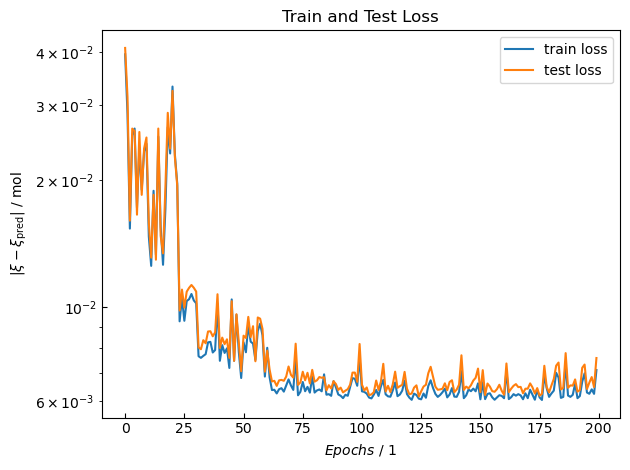

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9645408387406745
Test Dataset: R^2 = 0.9655327727988829


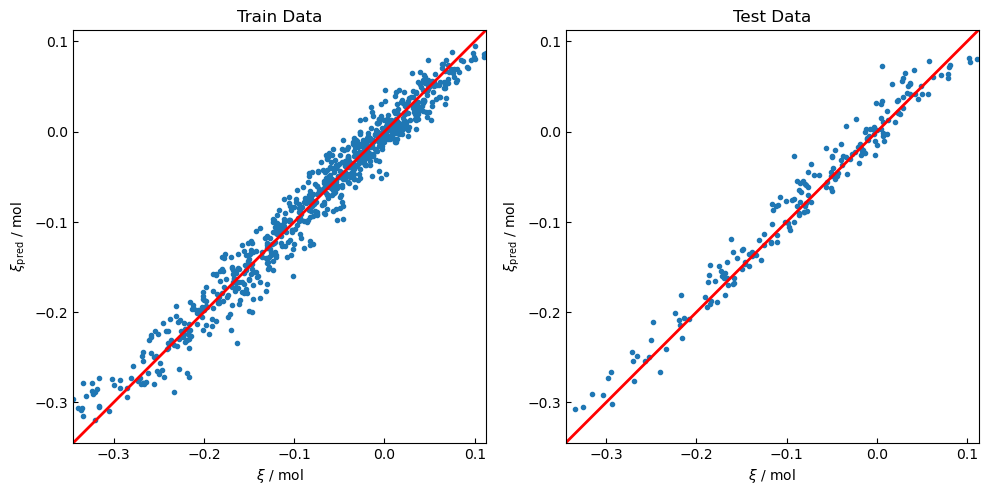

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())


print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))    

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

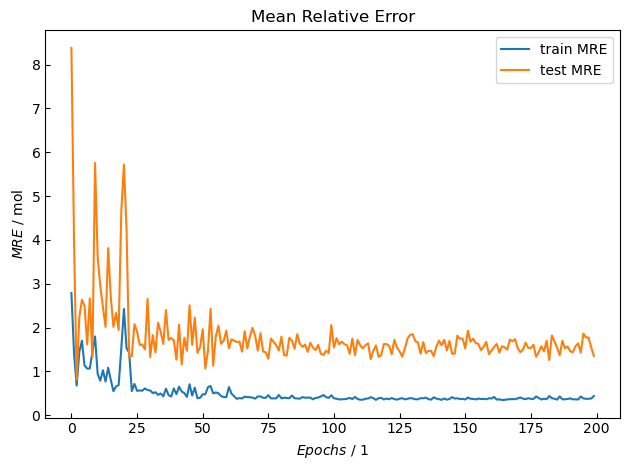

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

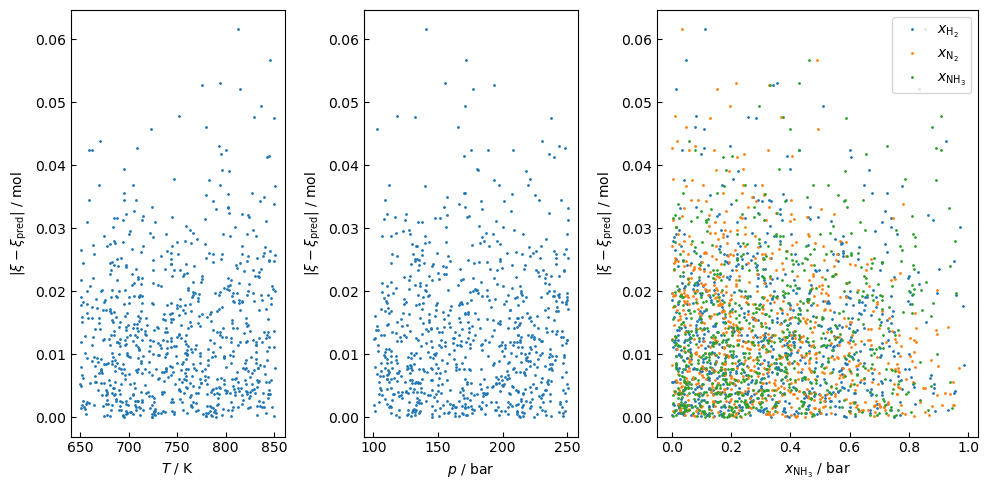

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

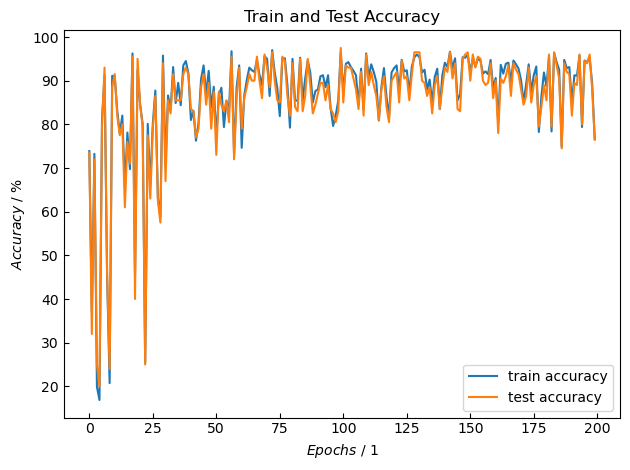

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.1486e+02, 1.7726e+02, 1.4007e-02, 1.5218e-01, 8.3381e-01],
        [7.8222e+02, 1.0961e+02, 1.3416e-02, 2.9572e-01, 6.9086e-01],
        [7.3076e+02, 2.3017e+02, 1.2465e-01, 5.6524e-01, 3.1011e-01],
        [7.5379e+02, 2.2449e+02, 4.9458e-01, 7.1706e-03, 4.9825e-01],
        [8.0430e+02, 1.3959e+02, 5.7874e-01, 5.7126e-02, 3.6413e-01],
        [8.1078e+02, 2.0722e+02, 5.1006e-02, 4.6819e-01, 4.8080e-01],
        [6.8063e+02, 1.9799e+02, 7.1986e-01, 2.5392e-02, 2.5475e-01],
        [6.8195e+02, 1.9374e+02, 9.3211e-01, 5.2748e-02, 1.5141e-02],
        [7.4978e+02, 2.4688e+02, 6.2549e-02, 3.7928e-01, 5.5817e-01],
        [7.6301e+02, 1.6681e+02, 8.5967e-01, 1.0198e-01, 3.8349e-02],
        [8.1189e+02, 1.9946e+02, 2.3713e-01, 9.0046e-02, 6.7283e-01],
        [7.1340e+02, 1.4198e+02, 5.8910e-01, 7.0767e-02, 3.4013e-01],
        [7.5880e+02, 2.2760e+02, 5.8959e-01, 5.7785e-02, 3.5263e-01],
        [8.2480e+02, 2.1500e+02, 1.2615e-01, 3.4089e-01, 5.3296e-01],
        [6.8953e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.6990, 0.5642, 0.8642, 0.7372, 0.8699], requires_grad=True),
 Parameter containing:
 tensor([-0.0856,  0.0398, -0.1295,  0.1833, -0.1332], requires_grad=True),
 Parameter containing:
 tensor([[-9.4166e-02, -5.7016e-02,  1.5543e-01,  1.2928e-01,  1.2601e-01],
         [-1.4723e-02,  6.8597e-02,  1.0000e-01,  1.0403e-01,  1.2124e-01],
         [-2.1549e-01,  3.3879e-01,  1.9646e-01, -4.3289e-02, -1.5630e-02],
         [-4.8171e-03,  1.3359e-02, -6.0515e-02, -5.3159e-02, -2.6843e-02],
         [ 4.3310e-02,  2.0496e-01, -1.7722e-02,  3.1619e-02,  1.5836e-01],
         [ 3.4005e-01,  4.0296e-02,  1.0466e-02,  3.1937e-02, -3.0596e-01],
         [-2.4914e-02, -8.5461e-02,  1.0659e-01,  1.3778e-01,  1.1616e-01],
         [-3.4414e-01, -9.4320e-02,  4.9190e-01, -3.1398e-01,  6.6803e-02],
         [ 9.3915e-02,  4.8224e-01,  4.1317e-01, -3.4408e-01, -9.5964e-02],
         [-1.5083e-01, -2.5454e-01,  1.0843e-01,  2.8981e-01,  3.5948e-01],
         [-2.8696e-01,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8114, 0.8310, 0.2585, 0.5428, 0.7080],
        [0.5992, 0.8344, 0.2516, 0.1438, 0.3136]])
tensor([[-0.0977],
        [-0.0116]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[7.9552e+02, 1.9802e+02, 1.4898e-02, 6.7249e-01, 3.1261e-01],
        [8.3342e+02, 1.2895e+02, 4.8415e-01, 1.0500e-01, 4.1085e-01],
        [8.2480e+02, 2.1500e+02, 1.2615e-01, 3.4089e-01, 5.3296e-01],
        [7.1001e+02, 2.4194e+02, 1.2142e-01, 2.6620e-01, 6.1238e-01],
        [8.1185e+02, 1.1529e+02, 4.6300e-01, 1.4389e-01, 3.9311e-01],
        [7.0838e+02, 1.2489e+02, 6.0602e-01, 9.5887e-03, 3.8439e-01],
        [7.5730e+02, 1.1356e+02, 1.2325e-01, 4.2649e-01, 4.5026e-01],
        [8.4121e+02, 1.3473e+02, 4.0342e-03, 9.5056e-01, 4.5407e-02],
        [6.9809e+02, 1.1200e+02, 3.7168e-01, 3.5344e-01, 2.7488e-01],
        [6.9385e+02, 2.5044e+02, 8.8262e-01, 3.7880e-03, 1.1359e-01],
        [7.6656e+02, 2.3153e+02, 4.4711e-01, 2.4900e-01, 3.0388e-01],
        [8.1268e+02, 2.5058e+02, 4.7227e-01, 3.7755e-01, 1.5018e-01],
        [7.8662e+02, 1.4209e+02, 1.3679e-01, 8.1887e-01, 4.4340e-02],
        [7.4393e+02, 2.2534e+02, 1.7544e-01, 5.6873e-01, 2.5582e-01],
        [7.8087e+02,